# **Import All Required Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from ast import literal_eval

In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import spacy

[nltk_data] Downloading package wordnet to C:\Users\Raksha
[nltk_data]     Rawat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [6]:
from surprise import Reader, Dataset, KNNBasic, SVD, NMF
from surprise.model_selection import cross_validate, GridSearchCV

In [7]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col, explode
from pyspark.sql import SparkSession

# **Content Filtering Based on Metadata**

In [8]:
df = pd.read_csv('movies_metadata.csv')
df.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0


In [9]:
df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [10]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [11]:
df['id'] = df['id'].apply(convert_int)

In [12]:
df[df['id'].isnull()]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",NaN,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",NaN,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df = df.drop([19730, 29503, 35587])

In [14]:
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')

In [15]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
df['id'] = df['id'].astype('int')

In [16]:
df = df.merge(credits, on='id')
df = df.merge(keywords, on='id')

In [17]:
df.drop_duplicates(subset= "title", keep = 'first', inplace = True)

In [18]:
links = pd.read_csv('links_small.csv')

In [19]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9125 non-null   int64  
 1   imdbId   9125 non-null   int64  
 2   tmdbId   9112 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 214.0 KB


In [20]:
links = links[links['tmdbId'].notnull()]['tmdbId'].astype('int')

In [21]:
smd = df[df['id'].isin(links)]
smd.shape

(8695, 27)

In [22]:
smd['year'] = pd.to_datetime(smd['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [23]:
smd['genres'] = smd['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [24]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [25]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [26]:
smd['director'] = smd['crew'].apply(get_director)

In [27]:
smd['director'].head(3)

0    John Lasseter
1     Joe Johnston
2    Howard Deutch
Name: director, dtype: object

In [28]:
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))

In [29]:
smd['director'] = smd['director'].apply(lambda x: [x, x])

In [30]:
smd['director'].head(3)

0    [johnlasseter, johnlasseter]
1      [joejohnston, joejohnston]
2    [howarddeutch, howarddeutch]
Name: director, dtype: object

In [31]:
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [32]:
smd['cast'].head(4)

0    [Tom Hanks, Tim Allen, Don Rickles, Jim Varney...
1    [Robin Williams, Jonathan Hyde, Kirsten Dunst,...
2    [Walter Matthau, Jack Lemmon, Ann-Margret, Sop...
3    [Whitney Houston, Angela Bassett, Loretta Devi...
Name: cast, dtype: object

In [33]:
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [34]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

Keywords Processing

In [35]:
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [36]:
smd['keywords']

0        [jealousy, toy, boy, friendship, friends, riva...
1        [board game, disappearance, based on children'...
2        [fishing, best friend, duringcreditsstinger, o...
3        [based on novel, interracial relationship, sin...
4        [baby, midlife crisis, confidence, aging, daug...
                               ...                        
40952                           [friendship, brick making]
41172                                          [bollywood]
41225                                          [bollywood]
41391    [monster, godzilla, giant monster, destruction...
41669                                 [music, documentary]
Name: keywords, Length: 8695, dtype: object

In [37]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [38]:
s = s.value_counts()
s[:5]

independent film        596
woman director          526
murder                  370
duringcreditsstinger    307
based on novel          292
Name: keyword, dtype: int64

In [39]:
s = s[s > 1]

In [40]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

### **Stemming**

In [41]:
stemmer = SnowballStemmer('english')

In [42]:
smd['stem_keywords'] = smd['keywords'].apply(filter_keywords)
smd['stem_keywords'] = smd['stem_keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['stem_keywords'] = smd['stem_keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [43]:
smd['stem_keywords'].head(6)

0    [jealousi, toy, boy, friendship, friend, rival...
1    [boardgam, disappear, basedonchildren'sbook, n...
2               [fish, bestfriend, duringcreditssting]
3    [basedonnovel, interracialrelationship, single...
4    [babi, midlifecrisi, confid, age, daughter, mo...
5    [robberi, detect, bank, obsess, chase, shoot, ...
Name: stem_keywords, dtype: object

In [44]:
smd['stem_keywords'][0]

['jealousi',
 'toy',
 'boy',
 'friendship',
 'friend',
 'rivalri',
 'boynextdoor',
 'newtoy',
 'toycomestolif']

In [45]:
smd['stem_keywords'][1]

['boardgam',
 'disappear',
 "basedonchildren'sbook",
 'newhom',
 'reclus',
 'giantinsect']

In [46]:
smd['stem_keywords'][2]

['fish', 'bestfriend', 'duringcreditssting']

In [47]:
smd['stem_keywords'][3]

['basedonnovel',
 'interracialrelationship',
 'singlemoth',
 'divorc',
 'chickflick']

In [48]:
smd['stem_keywords'][4]

['babi',
 'midlifecrisi',
 'confid',
 'age',
 'daughter',
 'motherdaughterrelationship',
 'pregnanc',
 'contracept',
 'gynecologist']

### **Lemmatizer**

In [49]:
lemmatizer = WordNetLemmatizer()

In [50]:
smd['lemmatizer_keywords'] = smd['keywords'].apply(filter_keywords)
smd['lemmatizer_keywords'] = smd['lemmatizer_keywords'].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
smd['lemmatizer_keywords'] = smd['lemmatizer_keywords'] .apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [51]:
smd['lemmatizer_keywords'].head(4)

0    [jealousy, toy, boy, friendship, friend, rival...
1    [boardgame, disappearance, basedonchildren'sbo...
2          [fishing, bestfriend, duringcreditsstinger]
3    [basedonnovel, interracialrelationship, single...
Name: lemmatizer_keywords, dtype: object

In [52]:
smd['lemmatizer_keywords'][0]

['jealousy',
 'toy',
 'boy',
 'friendship',
 'friend',
 'rivalry',
 'boynextdoor',
 'newtoy',
 'toycomestolife']

In [53]:
smd['lemmatizer_keywords'][1]

['boardgame',
 'disappearance',
 "basedonchildren'sbook",
 'newhome',
 'recluse',
 'giantinsect']

In [54]:
smd['lemmatizer_keywords'][2]

['fishing', 'bestfriend', 'duringcreditsstinger']

In [55]:
smd['lemmatizer_keywords'][3]

['basedonnovel',
 'interracialrelationship',
 'singlemother',
 'divorce',
 'chickflick']

In [56]:
smd['lemmatizer_keywords'][4]

['baby',
 'midlifecrisis',
 'confidence',
 'aging',
 'daughter',
 'motherdaughterrelationship',
 'pregnancy',
 'contraception',
 'gynecologist']

### **Lemmatization Using Spacy**

In [57]:
smd['doc_id'] = range(0, len(smd))

In [58]:
smd['spacy_keywords'] = smd['keywords'].astype('str')

In [59]:
nlp = spacy.load('en_core_web_sm')

In [60]:
docs = list(nlp.pipe(smd.spacy_keywords))

In [61]:
#Extract tokens and metadata from individual spaCy doc
def extract_tokens_plus_meta(doc:spacy.tokens.doc.Doc):
    return [(i.text, i.i, i.lemma_, i.pos_) for i in doc]

In [62]:
#Extract tokens and metadata from list of spaCy docs.
def tidy_tokens(docs):
    cols = ["doc_id", "token", "token_order", "keywords_from_spacy", "pos"]
    
    meta_df = []
    for ix, doc in enumerate(docs):
        meta = extract_tokens_plus_meta(doc)
        meta = pd.DataFrame(meta)
        meta.columns = cols[1:]
        meta = meta.assign(doc_id = ix).loc[:, cols]
        meta_df.append(meta)
    return pd.concat(meta_df)

In [63]:
kdf = tidy_tokens(docs)

In [64]:
kdf.head(10)

,doc_id,token,token_order,keywords_from_spacy,pos
0,0,[,0,[,PUNCT
1,0,',1,',PUNCT
2,0,jealousy,2,jealousy,NOUN
3,0,',3,',PUNCT
4,0,",",4,",",PUNCT
5,0,',5,',PUNCT
6,0,toy,6,toy,NOUN
7,0,',7,',PUNCT
8,0,",",8,",",PUNCT
9,0,',9,',PUNCT


In [65]:
kdf.pos.unique()

array(['PUNCT', 'NOUN', 'ADJ', 'VERB', 'ADP', 'PART', 'CCONJ', 'NUM', 'X',
       'ADV', 'DET', 'PROPN', 'SPACE', 'PRON', 'INTJ', 'AUX', 'SCONJ',
       'SYM'], dtype=object)

In [66]:
kdf = kdf[kdf.pos.isin(['NOUN', 'ADJ', 'VERB', 'PROPN', 'X', 'ADV', 'INTJ'])]

In [67]:
kdf.columns

Index(['doc_id', 'token', 'token_order', 'keywords_from_spacy', 'pos'], dtype='object')

In [68]:
kdf.drop(['token', 'token_order', 'pos'], axis=1, inplace=True)

In [69]:
kdf = kdf.groupby('doc_id').agg({'keywords_from_spacy': ' '.join}).reset_index()

In [70]:
kdf.head(3)

,doc_id,keywords_from_spacy
0,0,jealousy toy boy friendship friend rivalry boy...
1,1,board game disappearance base child book new h...
2,2,fishing good friend duringcreditsstinger old man


In [71]:
kdf['keywords_from_spacy'][0]

'jealousy toy boy friendship friend rivalry boy next door new toy toy come life'

In [72]:
kdf['keywords_from_spacy'][1]

'board game disappearance base child book new home recluse giant insect'

In [73]:
kdf['keywords_from_spacy'][2]

'fishing good friend duringcreditsstinger old man'

In [74]:
kdf['keywords_from_spacy'][3]

'base novel interracial relationship single mother divorce chick flick'

In [75]:
kdf['keywords_from_spacy'][4]

'baby midlife crisis confidence age daughter mother daughter relationship pregnancy contraception gynecologist'

Mergin Spacy Results to dataset

In [76]:
smd = smd.merge(kdf,on='doc_id')

In [77]:
smd.tail(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,keywords,year,cast_size,crew_size,director,stem_keywords,lemmatizer_keywords,doc_id,spacy_keywords,keywords_from_spacy
8693,False,NaN,15000000,"[Action, Adventure, Drama, Horror, Science Fic...",NaN,315011,tt4262980,ja,シン・ゴジラ,From the mind behind Evangelion comes a hit la...,...,"[monster, godzilla, giant monster, destruction...",2016,49,27,"[hideakianno, hideakianno]","[monster, godzilla, giantmonst, destruct, kaiju]","[monster, godzilla, giantmonster, destruction,...",8693,"['monster', 'godzilla', 'giant monster', 'dest...",monster godzilla giant monster destruction kai...
8694,False,NaN,0,"[Documentary, Music]",http://www.thebeatlesliveproject.com/,391698,tt2531318,en,The Beatles: Eight Days a Week - The Touring Y...,"The band stormed Europe in 1963, and, in 1964,...",...,"[music, documentary]",2016,28,7,"[ronhoward, ronhoward]","[music, documentari]","[music, documentary]",8694,"['music', 'documentary']",music documentary


In [78]:
smd.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew', 'keywords', 'year',
       'cast_size', 'crew_size', 'director', 'stem_keywords',
       'lemmatizer_keywords', 'doc_id', 'spacy_keywords',
       'keywords_from_spacy'],
      dtype='object')

In [79]:
smd[['cast','director','genres','keywords_from_spacy']].head(3)

,cast,director,genres,keywords_from_spacy
0,"[tomhanks, timallen, donrickles]","[johnlasseter, johnlasseter]","[Animation, Comedy, Family]",jealousy toy boy friendship friend rivalry boy...
1,"[robinwilliams, jonathanhyde, kirstendunst]","[joejohnston, joejohnston]","[Adventure, Fantasy, Family]",board game disappearance base child book new h...
2,"[waltermatthau, jacklemmon, ann-margret]","[howarddeutch, howarddeutch]","[Romance, Comedy]",fishing good friend duringcreditsstinger old man


In [80]:
smd['soup'] = smd['director'] + smd['cast'] + smd['genres']

In [81]:
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [82]:
smd['soup'].head(2)

0    johnlasseter johnlasseter tomhanks timallen do...
1    joejohnston joejohnston robinwilliams jonathan...
Name: soup, dtype: object

In [83]:
smd[['soup','keywords_from_spacy']]

,soup,keywords_from_spacy
0,johnlasseter johnlasseter tomhanks timallen do...,jealousy toy boy friendship friend rivalry boy...
1,joejohnston joejohnston robinwilliams jonathan...,board game disappearance base child book new h...
2,howarddeutch howarddeutch waltermatthau jackle...,fishing good friend duringcreditsstinger old man
3,forestwhitaker forestwhitaker whitneyhouston a...,base novel interracial relationship single mot...
4,charlesshyer charlesshyer stevemartin dianekea...,baby midlife crisis confidence age daughter mo...
...,...,...
8690,greggchampion greggchampion sidneypoitier wend...,friendship brick making
8691,tinusureshdesai tinusureshdesai akshaykumar il...,bollywood
8692,ashutoshgowariker ashutoshgowariker hrithikros...,bollywood
8693,hideakianno hideakianno hirokihasegawa yutakat...,monster godzilla giant monster destruction kai...


In [84]:
smd['combination'] = smd['soup'] + ' ' + smd['keywords_from_spacy']

In [85]:
smd.drop(['soup'], axis = 1, inplace = True)

In [86]:
smd['combination'].tail(2)

8693    hideakianno hideakianno hirokihasegawa yutakat...
8694    ronhoward ronhoward paulmccartney ringostarr j...
Name: combination, dtype: object

In [87]:
smd['combination']

0       johnlasseter johnlasseter tomhanks timallen do...
1       joejohnston joejohnston robinwilliams jonathan...
2       howarddeutch howarddeutch waltermatthau jackle...
3       forestwhitaker forestwhitaker whitneyhouston a...
4       charlesshyer charlesshyer stevemartin dianekea...
                              ...                        
8690    greggchampion greggchampion sidneypoitier wend...
8691    tinusureshdesai tinusureshdesai akshaykumar il...
8692    ashutoshgowariker ashutoshgowariker hrithikros...
8693    hideakianno hideakianno hirokihasegawa yutakat...
8694    ronhoward ronhoward paulmccartney ringostarr j...
Name: combination, Length: 8695, dtype: object

In [88]:
smd['combination'][0]

'johnlasseter johnlasseter tomhanks timallen donrickles Animation Comedy Family jealousy toy boy friendship friend rivalry boy next door new toy toy come life'

In [89]:
smd['combination'][1]

'joejohnston joejohnston robinwilliams jonathanhyde kirstendunst Adventure Fantasy Family board game disappearance base child book new home recluse giant insect'

In [90]:
smd['combination'][2]

'howarddeutch howarddeutch waltermatthau jacklemmon ann-margret Romance Comedy fishing good friend duringcreditsstinger old man'

In [91]:
smd['combination'][3]

'forestwhitaker forestwhitaker whitneyhouston angelabassett lorettadevine Comedy Drama Romance base novel interracial relationship single mother divorce chick flick'

In [92]:
smd.shape

(8695, 37)

In [93]:
smd.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew', 'keywords', 'year',
       'cast_size', 'crew_size', 'director', 'stem_keywords',
       'lemmatizer_keywords', 'doc_id', 'spacy_keywords',
       'keywords_from_spacy', 'combination'],
      dtype='object')

In [94]:
smd = smd[['id', 'title', 'combination']]

## **Tf-Idf**

In [95]:
tf = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 2), min_df = 0, stop_words ='english')
tfidf_matrix = tf.fit_transform(smd['combination'])

In [96]:
tfidf_matrix.shape

(8695, 113687)

In [97]:
sim_tfidf = linear_kernel(tfidf_matrix, tfidf_matrix)

## **Count Vectorizer**

In [98]:
count = CountVectorizer(analyzer = 'word', ngram_range = (1, 2), min_df = 0, stop_words ='english')
count_matrix = count.fit_transform(smd['combination'])

In [99]:
count_matrix.shape

(8695, 113687)

In [100]:
sim_cv = cosine_similarity(count_matrix, count_matrix)

## Content Filtering Recommendation System

In [101]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index = smd['title'])

In [102]:
smd.head(2)

,index,id,title,combination
0,0,862,Toy Story,johnlasseter johnlasseter tomhanks timallen do...
1,1,8844,Jumanji,joejohnston joejohnston robinwilliams jonathan...


In [103]:
def get_recommendations(title, method):
    idx = indices[title]
    sim_scores = list(enumerate(method[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    recommendations = pd.DataFrame(titles.iloc[movie_indices])
    print('Best Movie Recommendations are:')
    return recommendations.head(10).style.hide_index()

### Using Cosine Similarity with Tf-Idf

In [104]:
get_recommendations('The Godfather', sim_tfidf)

Best Movie Recommendations are:


title
The Godfather: Part II
Tucker: The Man and His Dream
The Cotton Club
The Godfather: Part III
The Rainmaker
Trial by Jury
Gardens of Stone
Peggy Sue Got Married
Rumble Fish
One from the Heart


In [105]:
get_recommendations('The Dark Knight', sim_tfidf)

Best Movie Recommendations are:


title
Batman Begins
The Dark Knight Rises
Batman Returns
Batman: Under the Red Hood
Batman & Robin
Batman
Batman Forever
Superman
The Prestige
Superman III


In [106]:
get_recommendations('Toy Story', sim_tfidf)

Best Movie Recommendations are:


title
Toy Story 2
Toy Story 3
Small Soldiers
Child's Play 2
Toy Story of Terror!
Luxo Jr.
Bride of Chucky
Cars 2
Child's Play 3
A Bug's Life


In [107]:
get_recommendations('Mean Girls', sim_tfidf)

Best Movie Recommendations are:


title
The DUFF
16 Wishes
Head Over Heels
17 Again
It's a Boy Girl Thing
Summer School
Ghosts of Girlfriends Past
American Pie Presents: The Book of Love
High School Musical 3: Senior Year
High School High


### Using Cosine Similarity with Count Vectorizer

In [108]:
get_recommendations('The Godfather', sim_cv)

Best Movie Recommendations are:


title
The Godfather: Part II
The Godfather: Part III
The Rainmaker
The Cotton Club
Trial by Jury
Batman Begins
Shoot the Piano Player
Point Blank
Black Mass
Tucker: The Man and His Dream


In [109]:
get_recommendations('The Dark Knight', sim_cv)

Best Movie Recommendations are:


title
Batman Begins
The Dark Knight Rises
Batman: Under the Red Hood
Batman & Robin
Batman Returns
Batman
Kick-Ass 2
Batman Forever
Superman
Batman: Year One


In [110]:
get_recommendations('Toy Story', sim_cv)

Best Movie Recommendations are:


title
Toy Story 2
Toy Story 3
Small Soldiers
Toy Story of Terror!
Child's Play 2
Bride of Chucky
Cars 2
Pinocchio
A Bug's Life
Ted


In [111]:
get_recommendations('Mean Girls', sim_cv)

Best Movie Recommendations are:


title
The DUFF
17 Again
Summer School
American Pie Presents: The Book of Love
16 Wishes
High School High
It's a Boy Girl Thing
Easy A
High School Musical 3: Senior Year
High School Musical


# **Collaborative Based Filtering**

In [112]:
reader = Reader()

In [113]:
df = pd.read_csv('ratings_small.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [114]:
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
data

In [115]:
trainset = data.build_full_trainset()

## **K-Nearest Neighbor (KNN)**

In [116]:
knn = KNNBasic()
cross_validate(knn, data, measures = ['RMSE'], cv = 5, verbose = True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9744  0.9665  0.9717  0.9651  0.9666  0.9688  0.0036  
Fit time          0.70    0.87    0.47    0.54    0.58    0.63    0.14    
Test time         4.47    3.84    3.69    4.18    3.73    3.98    0.30    


{'test_rmse': array([0.97436574, 0.96650597, 0.97165779, 0.96506661, 0.96655111]),
 'fit_time': (0.6971967220306396,
  0.8724844455718994,
  0.47184014320373535,
  0.5437507629394531,
  0.5770838260650635),
 'test_time': (4.471184253692627,
  3.835362672805786,
  3.69254994392395,
  4.180209398269653,
  3.734480142593384)}

In [117]:
#Hyperparameter Tuning
param_grid = {'k': list(range(10,45,5)), 'min_k' : list(range(1,7))}

knn_gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], return_train_measures = True, cv = 5)
knn_gs.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd

In [118]:
print('Best RMSE Score :', knn_gs.best_score['rmse'])
print('Best Parameters :', knn_gs.best_params['rmse'])

Best RMSE Score : 0.955340429222527
Best Parameters : {'k': 15, 'min_k': 3}


In [119]:
# Training Dataset on Optimized KNN Model
tuned_knn = KNNBasic(k = 15, min_k = 3, verbose = False)
tuned_knn.fit(trainset)

In [120]:
# userid: 1
# movieid: 31
# actual rating, r_ui: 2.5
tuned_knn.predict(1, 31, 2.5)

Prediction(uid=1, iid=31, r_ui=2.5, est=2.7563242531582075, details={'actual_k': 15, 'was_impossible': False})

In [121]:
tuned_knn.predict(1, 302)

Prediction(uid=1, iid=302, r_ui=None, est=3.6890085183191363, details={'actual_k': 5, 'was_impossible': False})

## **Singular Value Decomposition (SVD)**

In [122]:
svd = SVD()
cross_validate(svd, data, measures = ['RMSE'], cv = 5, verbose = True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8931  0.8932  0.8959  0.9039  0.9012  0.8975  0.0044  
Fit time          7.10    7.08    7.22    7.38    7.09    7.17    0.11    
Test time         0.24    0.25    0.23    0.23    0.23    0.24    0.01    


{'test_rmse': array([0.89312246, 0.89320546, 0.89586235, 0.90389908, 0.90123698]),
 'fit_time': (7.102997541427612,
  7.077159404754639,
  7.223963737487793,
  7.375387907028198,
  7.087148189544678),
 'test_time': (0.24263453483581543,
  0.24806451797485352,
  0.23206591606140137,
  0.23234319686889648,
  0.23242783546447754)}

In [171]:
#Hyperparameter Tuning
param_grid = {'n_factors': list(range(90,130,10)), 'n_epochs': list(range(10,50,10)), 'reg_all': np.arange(0.02,0.1,0.02), 
              'lr_all': [0.008,0.01,0.015,0.02]}

svd_gs = GridSearchCV(SVD, measures = ['RMSE'], param_grid = param_grid, cv = 5, return_train_measures = True)
svd_gs.fit(data)

print('Best Score :', svd_gs.best_score['rmse'])
print('Best Parameters :', svd_gs.best_params['rmse'])

Best Score : 0.8735065372444032
Best Parameters : {'n_factors': 110, 'n_epochs': 40, 'reg_all': 0.08, 'lr_all': 0.01}


In [123]:
# Training Dataset on Optimized SVD Model
tuned_svd = SVD(n_factors = 110, n_epochs = 40, reg_all = 0.08, lr_all = 0.01)
tuned_svd.fit(trainset)

In [124]:
tuned_svd.predict(1, 31, 2.5)

Prediction(uid=1, iid=31, r_ui=2.5, est=2.3416410700839796, details={'was_impossible': False})

In [125]:
tuned_svd.predict(1, 10000)

Prediction(uid=1, iid=10000, r_ui=None, est=2.649071578697286, details={'was_impossible': False})

## **Non-Negative Matrix Factorization (NMF)**

In [126]:
nmf = NMF()
cross_validate(nmf, data, measures = ['RMSE'], cv = 5, verbose = True)

Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9383  0.9405  0.9419  0.9582  0.9561  0.9470  0.0084  
Fit time          8.10    8.18    8.28    8.22    8.14    8.18    0.06    
Test time         0.22    0.19    0.19    0.19    0.19    0.20    0.01    


{'test_rmse': array([0.93829192, 0.9405148 , 0.94190578, 0.95822245, 0.95607671]),
 'fit_time': (8.09619951248169,
  8.176254034042358,
  8.276957273483276,
  8.222651958465576,
  8.14176607131958),
 'test_time': (0.21631431579589844,
  0.1920490264892578,
  0.1920485496520996,
  0.19205474853515625,
  0.1931607723236084)}

In [179]:
#Hyperparameters Tuning
param_grid  = {'n_factors': list(range(10,30,5)),'reg_pu': np.arange(0.02,0.1,0.02),'reg_qi': np.arange(0.02,0.1,0.02), 
               'n_epochs': list(range(30,70,10))}

nmf_gs = GridSearchCV(NMF, param_grid, measures = ['rmse'], return_train_measures = True, cv = 5)
nmf_gs.fit(data)

print('Best Score :', nmf_gs.best_score['rmse'])
print('Best Parameters :', nmf_gs.best_params['rmse'])

Best Score : 0.9271931038981307
Best Parameters : {'n_factors': 25, 'reg_pu': 0.08, 'reg_qi': 0.08, 'n_epochs': 60}


In [127]:
# Training Dataset on Optimized NMF Model
tuned_nmf = NMF(n_factors = 25, reg_pu = 0.08, reg_qi = 0.08, n_epochs = 60)
tuned_nmf.fit(trainset)

In [128]:
tuned_nmf.predict(1, 31, 2.5)

Prediction(uid=1, iid=31, r_ui=2.5, est=2.5668666074923054, details={'was_impossible': False})

In [129]:
tuned_nmf.predict(1, 303)

Prediction(uid=1, iid=303, r_ui=None, est=2.2930265446252847, details={'was_impossible': False})

## **Alternating Least Squares (ALS)**

In [16]:
spark = SparkSession.builder.appName("movierecommendation").getOrCreate()

In [17]:
df_als = spark.read.csv('ratings_small.csv', inferSchema = True, header=True)

In [18]:
df_als.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
|     1|   1029|   3.0|1260759179|
|     1|   1061|   3.0|1260759182|
|     1|   1129|   2.0|1260759185|
|     1|   1172|   4.0|1260759205|
+------+-------+------+----------+
only showing top 5 rows



In [19]:
df_als = df_als.drop('timestamp')

In [20]:
df_als.describe().show()

+-------+------------------+------------------+------------------+
|summary|            userId|           movieId|            rating|
+-------+------------------+------------------+------------------+
|  count|            100004|            100004|            100004|
|   mean| 347.0113095476181|12548.664363425463| 3.543608255669773|
| stddev|195.16383797819535|26369.198968815268|1.0580641091070326|
|    min|                 1|                 1|               0.5|
|    max|               671|            163949|               5.0|
+-------+------------------+------------------+------------------+



In [21]:
(train_als, test_als) = df_als.randomSplit([0.8, 0.2], seed = 42)

In [22]:
als = ALS(userCol = "userId", itemCol= "movieId", ratingCol = "rating", coldStartStrategy = "drop", nonnegative = True)

In [27]:
# tune model using ParamGridBuilder
param_grid = ParamGridBuilder()\
             .addGrid(als.rank, [5, 10, 15, 20])\
             .addGrid(als.maxIter, [10, 15, 20])\
             .addGrid(als.regParam, [0.01, 0.05, 0.1])\
             .build()

In [28]:
evaluator = RegressionEvaluator(metricName = "rmse", labelCol = "rating", predictionCol = "prediction")

In [29]:
cv = CrossValidator(estimator = als, estimatorParamMaps = param_grid, evaluator = evaluator, numFolds = 5) 

In [30]:
model = cv.fit(train_als)

In [31]:
best_model = model.bestModel

In [32]:
predictions_als = best_model.transform(test_als)
rmse = evaluator.evaluate(predictions_als)
print(rmse)

0.9088912679644156


In [33]:
predictions_als.show(10)

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   463|   1088|   3.0| 3.0499327|
|   463|   1959|   4.0|  3.713252|
|   463|   2122|   2.0| 1.9622345|
|   243|   1645|   3.0| 3.3717885|
|   251|   1580|   5.0| 4.0574064|
|   255|   6620|   4.0|  4.389491|
|   481|   8638|   3.0|  4.514176|
|   133|   8638|   0.5| 1.9405539|
|   472|  26425|   4.5|  3.069398|
|   472|  44022|   3.5| 2.8903637|
+------+-------+------+----------+
only showing top 10 rows



In [34]:
print("RMSE = ", str(rmse)) 
print("Best Model: ")
print("Rank:", best_model.rank)
print("MaxIter:", best_model._java_obj.parent().getMaxIter()) 
print("RegParam:", best_model._java_obj.parent().getRegParam()) 

RMSE =  0.9088912679644156
Best Model: 
Rank: 5
MaxIter: 20
RegParam: 0.1


In [36]:
# give 30 recommendations for all users
nrecommendations = best_model.recommendForAllUsers(30)
nrecommendations.limit(10).show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|     1|[{2285, 4.0076323...|
|     3|[{83411, 4.922976...|
|     5|[{4965, 5.408834}...|
|     6|[{67504, 5.371087...|
|     9|[{83411, 5.560284...|
|    12|[{3414, 5.7732315...|
|    13|[{8530, 4.8549914...|
|    15|[{3672, 4.941078}...|
|    16|[{3414, 6.3760657...|
|    17|[{83318, 5.999473...|
+------+--------------------+



In [37]:
nrecommendations = nrecommendations\
                  .withColumn("rec_exp", explode("recommendations"))\
                  .select('userId', col("rec_exp.movieId"), col("rec_exp.rating"))

nrecommendations.limit(10).show()

+------+-------+---------+
|userId|movieId|   rating|
+------+-------+---------+
|     1|   2285|4.0076323|
|     1|  92494| 4.001041|
|     1|  40412| 4.001041|
|     1|   3216| 4.001041|
|     1|  97957|  3.89317|
|     1|  26974|3.8926685|
|     1|   3067|3.8884382|
|     1|   4965|3.8724036|
|     1|   6732|3.8676362|
|     1|   4754| 3.838958|
+------+-------+---------+



In [159]:
# User 1 Recommendations
userid = 1
print('Recommendations for User', userid, 'are: ')
nrecommendations.filter('userId = userid').show()

Recommendations for User 1 are: 
+------+-------+---------+
|userId|movieId|   rating|
+------+-------+---------+
|     1|   2285|4.0076323|
|     1|  92494| 4.001041|
|     1|  40412| 4.001041|
|     1|   3216| 4.001041|
|     1|  97957|  3.89317|
|     1|  26974|3.8926685|
|     1|   3067|3.8884382|
|     1|   4965|3.8724036|
|     1|   6732|3.8676362|
|     1|   4754| 3.838958|
|     1|  73290|3.7634146|
|     1|  70293|3.7002847|
|     1|  67504|3.6683419|
|     1|  83411|3.6683419|
|     1|  83318|3.6683419|
|     1|  83359|3.6683419|
|     1|   7027|3.6682146|
|     1|   3437|  3.62723|
|     1|   5765|  3.62723|
|     1|   4630|  3.62723|
+------+-------+---------+
only showing top 20 rows



## **Collaborative Filtering Recommendation System**

In [130]:
def cf_recommendations(algo, uid, iid = None):
    mvtn = smd[['title', 'id']]
    mvtn['id'] = mvtn['id'].astype('int')
    mvtn['title'] = mvtn['title'].astype('str')
    mvtn.rename(columns = {'id':'movieId'}, inplace = True)
    mvtn.rename(columns = {'title':'Movie Title'}, inplace = True)
    
    if algo == 'als':
        recommendations_pd = nrecommendations.toPandas()
        als_recommendations = pd.merge(recommendations_pd, mvtn, on='movieId')
        als_recommendations = als_recommendations[als_recommendations['userId'] == uid]
        als_recommendations.rename(columns = {'rating':'Estimated Rating'}, inplace = True)
        als_recommendations = als_recommendations.sort_values(by=['Estimated Rating'], ascending = False)
        als_recommendations = als_recommendations[['movieId', 'Movie Title', 'Estimated Rating']]
        print('Best Recommended Movies for User', uid, 'are: ')
        return als_recommendations.head(10).style.hide_index()
    
    else:
        other_predictions = []
        if iid is None:
            for ii in trainset.all_items():
                ii = trainset.to_raw_iid(ii)
                other_predictions.append(algo.predict(uid, ii, verbose = False))
        
        else:
            other_predictions.append(algo.predict(uid,iid,verbose = False))
        
        other_predictions_df = pd.DataFrame(other_predictions, columns = ['userId', 'movieId', 'r_ui', 'Estimated Rating', 'details'])
        other_predictions_df['details'] = other_predictions_df['details'].astype('str')
        other_predictions_df = other_predictions_df[~other_predictions_df.details.str.contains('|'.join(["'was_impossible': True"]))]
        other_recommendations = pd.merge(other_predictions_df, mvtn, on='movieId')
        other_recommendations = other_recommendations.sort_values(by=['Estimated Rating'], ascending = False)
        other_recommendations = other_recommendations[['Movie Title', 'Estimated Rating']]
        print('Best Recommended Movies for User', uid, 'are:')
        return other_recommendations.head(10).style.hide_index()

In [211]:
cf_recommendations(als, 20)

Best Recommended Movies for User 20 are: 


movieId,Movie Title,Estimated Rating
392,Chocolat,4.916078
80,Before Sunset,4.747125
4474,My Super Ex-Girlfriend,4.679991
1429,25th Hour,4.581765
1824,50 First Dates,4.573413
321,Mambo Italiano,4.549988
631,Sunrise: A Song of Two Humans,4.474201


In [212]:
cf_recommendations(als, 19)

Best Recommended Movies for User 19 are: 


movieId,Movie Title,Estimated Rating
759,Gentlemen Prefer Blondes,4.701950
5121,The Sugarland Express,4.693653
80,Before Sunset,4.641944
764,The Evil Dead,4.641840


In [213]:
cf_recommendations(als, 58)

Best Recommended Movies for User 58 are: 


movieId,Movie Title,Estimated Rating
301,Rio Bravo,5.607272
1428,Once Upon a Time in Mexico,5.607272
1429,25th Hour,5.506824
80,Before Sunset,5.341999
392,Chocolat,5.180208
3090,The Treasure of the Sierra Madre,5.122047


In [131]:
cf_recommendations(tuned_knn, uid = 20)

Best Recommended Movies for User 20 are:


Movie Title,Estimated Rating
The Night of the Hunter,5.000000
The Celebration,5.000000
Taxi,4.765227
Match Point,4.740612
Blown Away,4.711463
Body Snatchers,4.671016
Backdraft,4.584187
Tokyo!,4.575161
Z,4.553886
Before Sunset,4.546520


In [132]:
cf_recommendations(tuned_svd, uid = 20)

Best Recommended Movies for User 20 are:


Movie Title,Estimated Rating
Irma la Douce,4.531441
The Green Mile,4.501913
King Kong vs. Godzilla,4.440128
The Sixth Sense,4.414665
The Passion of Joan of Arc,4.253854
American Graffiti,4.180315
Before Sunset,4.149670
Crank,4.058061
M,3.988412
Bullitt,3.972731


In [133]:
cf_recommendations(tuned_nmf, uid = 20)

Best Recommended Movies for User 20 are:


Movie Title,Estimated Rating
Ice Age: The Meltdown,4.464260
The First Wives Club,4.172508
Irma la Douce,4.155328
Kindergarten Cop,4.121227
Straw Dogs,4.102031
My Darling Clementine,4.085481
Lethal Weapon 2,4.083358
Dog Day Afternoon,4.061591
Doctor Zhivago,4.060165
Snakes on a Plane,4.052289


## **RMSE Comparison**

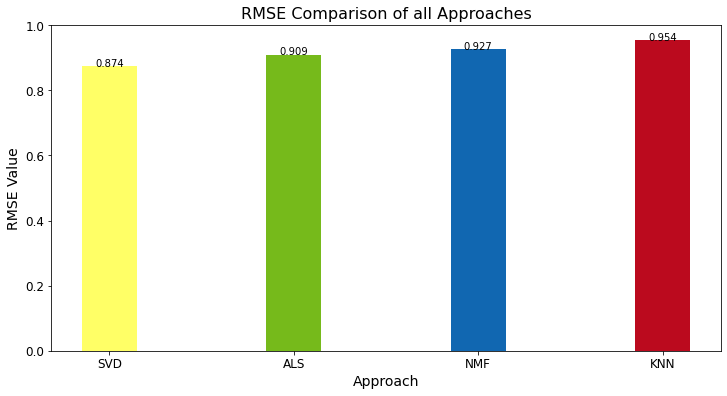

In [134]:
plot_data = {'KNN': 0.9538736787202492, 'SVD': 0.8735065372444032, 'NMF': 0.9271931038981307, 'ALS': 0.9088912679644156}
plot_data = dict(sorted(plot_data.items(), key=lambda item: item[1]))
plot_data = {key : round(plot_data[key], 3) for key in plot_data}

method = list(plot_data.keys())
rmse = list(plot_data.values())
  
fig = plt.figure(figsize = (12, 6))
plt.bar(method, rmse, width = 0.3, color = ['#FFFF66', '#76BA1B', '#1167b1','#bb0a1e'])

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

addlabels(method, rmse)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Approach", size = 14)
plt.ylabel("RMSE Value", size = 14)
plt.title("RMSE Comparison of all Approaches", size = 16)
plt.show()

# **Hybrid Recommendation System**

In [135]:
id_map = pd.read_csv('links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')
id_map.head()

,movieId,id
title,,
Toy Story,1,862.0
Jumanji,2,8844.0
Grumpier Old Men,3,15602.0
Waiting to Exhale,4,31357.0
Father of the Bride Part II,5,11862.0


In [136]:
indices_map = id_map.set_index('id')

In [137]:
def hybrid(userId, title):
    if title in smd.title.unique():
            idx = indices[title]
            tmdbId = id_map.loc[title]['id']
            movie_id = id_map.loc[title]['movieId']
            
            sim_scores = list(enumerate(sim_tfidf[int(idx)]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            sim_scores = sim_scores[1:31]
            movie_indices = [i[0] for i in sim_scores]
            movies = smd.iloc[movie_indices][['title', 'id']]
            
            if userId in df.userId.unique():
                movies['Estimated Rating'] = movies['id'].apply(lambda x: tuned_svd.predict(userId, indices_map.loc[x]['movieId']).est)
                movies = movies.sort_values('Estimated Rating', ascending = False)
                print('Best Recommendations for User', userId, 'are: ')
                return movies[['title', 'Estimated Rating']].head(10).style.hide_index()
            else:
                movies = pd.DataFrame(movies, columns = ['id', 'title'])
                print('Best Recommendations for New User', userId, 'are: ')
                return movies['title'].head(10)
            
    else:
        if userId in df.userId.unique():
            print('OOPS sorry searched movie is not present in the database but according to your previous choices')
            return cf_recommendations(tuned_svd, userId)
        else:
            return 'Sorry! we cannot provide you recommendations, the userId and the movie does not exist in our database, Please try again'

In [138]:
# both movie title and input userId both are present in the database
hybrid(1, 'Toy Story')

Best Recommendations for User 1 are: 


title,Estimated Rating
Toy Story 3,3.230614
Ted 2,3.198127
The Lego Movie,3.194645
Creature Comforts,3.090387
Big,2.984964
Toy Story of Terror!,2.839068
The Transformers: The Movie,2.766230
Toy Story 2,2.747692
Luxo Jr.,2.747402
Mr. Magorium's Wonder Emporium,2.723968


In [139]:
# movie title is present in the database but userId is not present in the database
hybrid(100000, 'Toy Story')

Best Recommendations for New User 100000 are: 


2470             Toy Story 2
7287             Toy Story 3
1475          Small Soldiers
1545          Child's Play 2
8093    Toy Story of Terror!
6142                Luxo Jr.
1818         Bride of Chucky
7541                  Cars 2
1546          Child's Play 3
1852            A Bug's Life
Name: title, dtype: object

In [140]:
# movie title is not present in the database but userId is present in the database
hybrid(1, 'T')

OOPS sorry searched movie is not present in the database but according to your previous choices
Best Recommended Movies for User 1 are:


Movie Title,Estimated Rating
Sleepless in Seattle,3.501990
Backdraft,3.483475
Dr. Jekyll and Mr. Hyde,3.446307
My Darling Clementine,3.442757
Pandora's Box,3.439098
The Sugarland Express,3.431462
Taxi,3.423819
Rumble Fish,3.421605
License to Wed,3.386992
Nell,3.385506


In [141]:
# Neither movie title nor userId present in the database
hybrid(50000, 'T')

'Sorry! we cannot provide you recommendations, the userId and the movie does not exist in our database, Please try again'